In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.1.0
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available() == True)

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? ㅛ
Your response ('ㅛ') was not one of the expected responses: y, n
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 421.8MB 43kB/s 
     |████████████████████████████████| 450kB 41.3MB/s 
     |████████████████████████████████| 3.9MB 33.7MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing i

bit.ly/newsqa-download 에서 다운로드해서 업로드

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My Drive/딥러닝/텐서플로우2.0/Generative Deep Learning

/content/drive/My Drive/딥러닝/텐서플로우2.0/Generative Deep Learning


In [0]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available() == True)

2.1.0
True


In [0]:
import os

In [0]:
# run params
SECTION = 'write'
RUN_ID = '0001'
DATA_NAME = 'qa'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [0]:
from collections import Counter

import csv

import random

import numpy as np

import os.path


_MAX_BATCH_SIZE = 128
_MAX_DOC_LENGTH = 200

PADDING_WORD = "<PAD>"
UNKNOWN_WORD = "<UNK>"
START_WORD = "<START>"
END_WORD = "<END>"

_word_to_idx = {}
_idx_to_word = []


def _add_word(word):
    idx = len(_idx_to_word)
    _word_to_idx[word] = idx
    _idx_to_word.append(word)
    return idx


PADDING_TOKEN = _add_word(PADDING_WORD)
UNKNOWN_TOKEN = _add_word(UNKNOWN_WORD)
START_TOKEN = _add_word(START_WORD)
END_TOKEN = _add_word(END_WORD)


embeddings_path = 'write/glove.6B.100d.trimmed.txt'

if os.path.exists(embeddings_path):
    with open(embeddings_path) as f:
        line = f.readline()
        chunks = line.split(" ")
        dimensions = len(chunks) - 1
        f.seek(0)

        vocab_size = sum(1 for line in f)
        vocab_size += 4 #3
        f.seek(0)

        glove = np.ndarray((vocab_size, dimensions), dtype=np.float32)
        glove[PADDING_TOKEN] = np.random.normal(0, 0.02, dimensions)
        glove[UNKNOWN_TOKEN] = np.random.normal(0, 0.02, dimensions)
        glove[START_TOKEN] = np.random.normal(0, 0.02, dimensions)
        glove[END_TOKEN] = np.random.normal(0, 0.02, dimensions)

        for line in f:
            chunks = line.split(" ")
            idx = _add_word(chunks[0])
            glove[idx] = [float(chunk) for chunk in chunks[1:]]
            if len(_idx_to_word) >= vocab_size:
                break




def look_up_word(word):
    return _word_to_idx.get(word, UNKNOWN_TOKEN)


def look_up_token(token):
    return _idx_to_word[token]



def _tokenize(string):
    return [word.lower() for word in string.split(" ")]


def _prepare_batch(batch):
    id_to_indices = {}
    document_ids = []
    document_text = []
    document_words = []
    answer_text = []
    answer_indices = []
    question_text = []
    question_input_words = []
    question_output_words = []
    for i, entry in enumerate(batch):
        id_to_indices.setdefault(entry["document_id"], []).append(i)
        document_ids.append(entry["document_id"])
        document_text.append(entry["document_text"])
        document_words.append(entry["document_words"])
        answer_text.append(entry["answer_text"])
        answer_indices.append(entry["answer_indices"])
        question_text.append(entry["question_text"])

        question_words = entry["question_words"]
        question_input_words.append([START_WORD] + question_words)
        question_output_words.append(question_words + [END_WORD])

    batch_size = len(batch)
    max_document_len = max((len(document) for document in document_words), default=0)
    max_answer_len = max((len(answer) for answer in answer_indices), default=0)
    max_question_len = max((len(question) for question in question_input_words), default=0)

    document_tokens = np.zeros((batch_size, max_document_len), dtype=np.int32)
    document_lengths = np.zeros(batch_size, dtype=np.int32)
    answer_labels = np.zeros((batch_size, max_document_len), dtype=np.int32)
    answer_masks = np.zeros((batch_size, max_answer_len, max_document_len), dtype=np.int32)
    answer_lengths = np.zeros(batch_size, dtype=np.int32)
    question_input_tokens = np.zeros((batch_size, max_question_len), dtype=np.int32)
    question_output_tokens = np.zeros((batch_size, max_question_len), dtype=np.int32)
    question_lengths = np.zeros(batch_size, dtype=np.int32)

    for i in range(batch_size):
        for j, word in enumerate(document_words[i]):
            document_tokens[i, j] = look_up_word(word)
        document_lengths[i] = len(document_words[i])

        for j, index in enumerate(answer_indices[i]):
            for shared_i in id_to_indices[batch[i]["document_id"]]:
                answer_labels[shared_i, index] = 1
            answer_masks[i, j, index] = 1
        answer_lengths[i] = len(answer_indices[i])

        for j, word in enumerate(question_input_words[i]):
            question_input_tokens[i, j] = look_up_word(word)
        for j, word in enumerate(question_output_words[i]):
            question_output_tokens[i, j] = look_up_word(word)
        question_lengths[i] = len(question_input_words[i])

    return {
        "size": batch_size,
        "document_ids": document_ids,
        "document_text": document_text,
        "document_words": document_words,
        "document_tokens": document_tokens,
        "document_lengths": document_lengths,
        "answer_text": answer_text,
        "answer_indices": answer_indices,
        "answer_labels": answer_labels,
        "answer_masks": answer_masks,
        "answer_lengths": answer_lengths,
        "question_text": question_text,
        "question_input_tokens": question_input_tokens,
        "question_output_tokens": question_output_tokens,
        "question_lengths": question_lengths,
    }


def collapse_documents(batch):
    seen_ids = set()
    keep = []

    for i in range(batch["size"]):
        id = batch["document_ids"][i]
        if id in seen_ids:
            continue

        keep.append(i)
        seen_ids.add(id)

    result = {}
    for key, value in batch.items():
        if key == "size":
            result[key] = len(keep)
        elif isinstance(value, np.ndarray):
            result[key] = value[keep]
        else:
            result[key] = [value[i] for i in keep]
    return result


def expand_answers(batch, answers):
    new_batch = []

    for i in range(batch["size"]):
        split_answers = []
        last = None
        for j, tag in enumerate(answers[i]):
            if tag:
                if last != j - 1:
                    split_answers.append([])
                split_answers[-1].append(j)
                last = j

        if len(split_answers) > 0:

            answer_indices = split_answers[0]
        # for answer_indices in split_answers:
            document_id = batch["document_ids"][i]
            document_text = batch["document_text"][i]
            document_words = batch["document_words"][i]
            answer_text = " ".join(document_words[i] for i in answer_indices)
            new_batch.append({
                "document_id": document_id,
                "document_text": document_text,
                "document_words": document_words,
                "answer_text": answer_text,
                "answer_indices": answer_indices,
                "question_text": "",
                "question_words": [],
            })
        else:
            new_batch.append({
                "document_id": batch["document_ids"][i],
                "document_text": batch["document_text"][i],
                "document_words": batch["document_words"][i],
                "answer_text": "",
                "answer_indices": [],
                "question_text": "",
                "question_words": [],
            })

    return _prepare_batch(new_batch)


def _read_data(path):
    stories = {}

    with open(path) as f:
        header_seen = False
        for row in csv.reader(f):
            if not header_seen:
                header_seen = True
                continue

            document_id = row[0]

            existing_stories = stories.setdefault(document_id, [])

            document_text = row[1]
            if existing_stories and document_text == existing_stories[0]["document_text"]:
                # Save memory by sharing identical documents
                document_text = existing_stories[0]["document_text"]
                document_words = existing_stories[0]["document_words"]
            else:
                document_words = _tokenize(document_text)
                document_words = document_words[:_MAX_DOC_LENGTH]

            question_text = row[2]
            question_words = _tokenize(question_text)

            answer = row[3]
            answer_indices = []
            for chunk in answer.split(","):
                start, end = (int(index) for index in chunk.split(":"))
                if end < _MAX_DOC_LENGTH:
                    answer_indices.extend(range(start, end))
            answer_text = " ".join(document_words[i] for i in answer_indices)

            if len(answer_indices) > 0:
                existing_stories.append({
                    "document_id": document_id,
                    "document_text": document_text,
                    "document_words": document_words,
                    "answer_text": answer_text,
                    "answer_indices": answer_indices,
                    "question_text": question_text,
                    "question_words": question_words,
                })

     

    return stories


def _process_stories(stories):
    batch = []
    vals = list(stories.values())
    random.shuffle(vals)

    for story in vals:
        if len(batch) + len(story) > _MAX_BATCH_SIZE:
            yield _prepare_batch(batch)
            batch = []
        batch.extend(story)

    if batch:
        yield _prepare_batch(batch)


_training_stories = None
_test_stories = None

def _load_training_stories():
    global _training_stories
    _training_stories = _read_data("write/train.csv")
    return _training_stories

def _load_test_stories():
    global _test_stories
    _test_stories = _read_data("write/my_test.csv")
    return _test_stories

def training_data():
    return _process_stories(_load_training_stories())

def test_data():
    return _process_stories(_load_test_stories())


def trim_embeddings():
    document_counts = Counter()
    question_counts = Counter()
    for data in [_load_training_stories().values(), _load_test_stories().values()]:
        
        for stories in data:

            if len(stories) > 0:
                document_counts.update(stories[0]["document_words"])
                for story in stories:
                    question_counts.update(story["question_words"])

    keep = set()
    for word, count in question_counts.most_common(5000):
        keep.add(word)
    for word, count in document_counts.most_common():
        if len(keep) >= 10000:
            break
        keep.add(word)

    with open("write/glove.6B.100d.txt") as f:
        with open("write/glove.6B.100d.trimmed.txt", "w") as f2:
            for line in f:
                if line.split(" ")[0] in keep:
                    f2.write(line)

In [0]:
training_data_gen = training_data()
# training_data_gen = [next(training_data_gen)]
test_data_gen = test_data()

In [0]:
t = next(training_data_gen)

In [21]:
look_up_token(66)

'--'

In [25]:
idx = 0
print(t['document_text'][idx])
print('\n')
print('document_tokens\n', t['document_tokens'][idx])
print('\n')
print('question_input_tokens\n', t['question_input_tokens'][idx])
print('\n')
print('answer_masks\n', t['answer_masks'][idx])
print('\n')
print('answer_labels\n', t['answer_labels'][idx])
print('\n')
print('question_output_tokens\n', t['question_output_tokens'][idx])

LOS ANGELES , California -LRB- CNN -RRB- -- In her first television interview since Mel Gibson went public with their relationship in April , his girlfriend , Oksana Grigorieva , made it clear to CNN : `` I 'd like to be known for my music . '' Oksana Grigorieva and Mel Gibson are expecting a child this year . Still , the 39-year-old singer was willing to talk about her beau and her pregnancy , as well as her new album , `` Beautiful Heartache . '' `` Beautiful Heartache '' was released to iTunes on July 23 by Icon Distribution , Gibson 's company , which up until now has handled only soundtracks for his movies . `` He 's an incredible artist , '' Grigorieva said . `` A visionary . He enabled me to produce this album , for my music to live . '' The Oscar-winning -LRB- `` Braveheart '' -RRB- filmmaker also directed four music videos for Grigorieva during a whirlwind week in Mexico . Watch Grigorieva talk about Gibson , love '' `` They 're like dramatic miniature films -- a whirlpool of 

In [38]:
print('answer_labels\n', t['answer_labels'][0])

answer_labels
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [39]:
print('answer_labels\n', t['answer_labels'][1])

answer_labels
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [37]:
t['answer_text'][idx]

'oksana grigorieva and mel gibson'

In [0]:
tmp=t['answer_labels'][idx].copy()

In [28]:
np.where(tmp==1)

(array([24, 25, 27, 28, 48, 49, 50, 51, 52, 54, 55, 56, 64, 84, 85]),)

In [36]:
t['document_text'][idx].split(' ')[25]

'girlfriend'

In [10]:
VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

print('GLOVE')
print('VOCAB_SIZE: ', VOCAB_SIZE)
print('EMBEDDING_DIMENS: ', EMBEDDING_DIMENS)

GRU_UNITS = 100

GLOVE
VOCAB_SIZE:  9984
EMBEDDING_DIMENS:  100


In [0]:
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

In [0]:
document_tokens = tf.keras.layers.Input(shape=(MAX_DOC_SIZE,),name = 'document_tokens')

embedding = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,output_dim=EMBEDDING_DIMENS,weights=[glove],mask_zero=True,name='embedding')
document_emb = embedding(document_tokens)
answer_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_UNITS,return_sequences=True),name='answer_outputs')(document_emb)
answer_tags = tf.keras.layers.Dense(2,activation='softmax',name='answer_tags')(answer_outputs)

In [0]:
encoder_input_mask = tf.keras.layers.Input(shape=(MAX_ANSWER_SIZE,MAX_DOC_SIZE),name='encoder_input_mask')
encoder_inputs = tf.keras.layers.Lambda(lambda x: tf.keras.backend.batch_dot(x[0],x[1]),name='encoder_inputs')([encoder_input_mask,answer_outputs])
encoder_cell = tf.keras.layers.GRU(2*GRU_UNITS, name='encoder_cell')(encoder_inputs)

In [0]:
decoder_inputs=tf.keras.layers.Input(shape=(MAX_Q_SIZE,),name='decoder_inputs')
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable=False
decoder_cell = tf.keras.layers.GRU(2*GRU_UNITS,return_sequences=True,name='decoder_dell')
decoder_states=decoder_cell(decoder_emb,initial_state=[encoder_cell])

In [0]:
decoder_projection = tf.keras.layers.Dense(VOCAB_SIZE,name='decoder_projection',activation='softmax',use_bias=False)
decoder_outputs=decoder_projection(decoder_states)

In [0]:
total_model=tf.keras.Model([document_tokens,decoder_inputs,encoder_input_mask],[answer_tags,decoder_outputs])

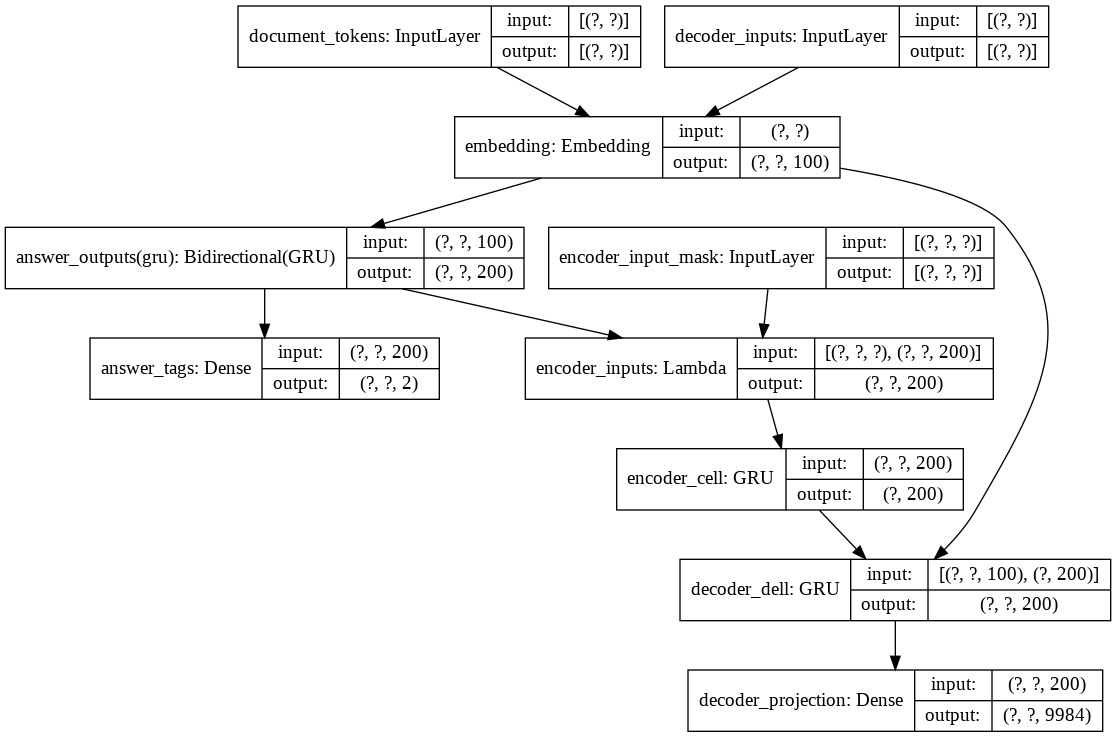

In [45]:
tf.keras.utils.plot_model(total_model,show_shapes=True)

In [0]:
decoder_emb.shape

TensorShape([None, None, 100])

In [0]:
answer_model = tf.keras.Model(document_tokens,[answer_tags])
decoder_initial_state_model=tf.keras.Model([document_tokens,encoder_input_mask],[encoder_cell])

In [0]:
total_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
document_tokens (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    998400      document_tokens[0][0]            
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
answer_outputs (Bidirectional)  (None, None, 200)    121200      embedding[0][0]                  
__________________________________________________________________________________________________
encoder_input_mask (InputLayer) [(None, None, None)] 0                                        

In [0]:
opti = tf.keras.optimizers.Adam(lr=0.001)
total_model.compile(loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy']
                    , optimizer=opti
                    , loss_weights = [1,1]) 

In [0]:
training_loss_history = []
test_loss_history = []

EPOCHS = 2000
start_epoch = 1

In [0]:
for epoch in range(start_epoch, start_epoch + EPOCHS + 1):
    print("에포크 {0}".format(epoch))
    
    for i, batch in enumerate(training_data()):
        
        val_batch = next(test_data_gen, None)
        
        if val_batch is None:
            test_data_gen = test_data()
            val_batch = next(test_data_gen, None)
            
        training_loss = total_model.train_on_batch(
            [batch['document_tokens'], batch['question_input_tokens'], batch['answer_masks']]
            , [np.expand_dims(batch['answer_labels'], axis = -1), np.expand_dims(batch['question_output_tokens'], axis = -1)]
        )
        
        test_loss = total_model.test_on_batch(
            [val_batch['document_tokens'], val_batch['question_input_tokens'], val_batch['answer_masks']]
            , [np.expand_dims(val_batch['answer_labels'], axis = -1), np.expand_dims(val_batch['question_output_tokens'], axis = -1)]
        )
        
        training_loss_history.append(training_loss)
        test_loss_history.append(test_loss)
    
    if epoch % 100 == 0:
        print("{}: 훈련 손실: {} | 테스트 손실: {}".format(i, training_loss, test_loss))    
        total_model.save_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(epoch)))

에포크 1
에포크 2
에포크 3
에포크 4
에포크 5
에포크 6
에포크 7
에포크 8
에포크 9
에포크 10
에포크 11
에포크 12
에포크 13
에포크 14
에포크 15
에포크 16
에포크 17
에포크 18
에포크 19
에포크 20
에포크 21
에포크 22
에포크 23
에포크 24
에포크 25
에포크 26
에포크 27
에포크 28
에포크 29
에포크 30
에포크 31
에포크 32
에포크 33
에포크 34
에포크 35
에포크 36
에포크 37
에포크 38
에포크 39
에포크 40
에포크 41
에포크 42
에포크 43
에포크 44
에포크 45
에포크 46
에포크 47
에포크 48
에포크 49
에포크 50
에포크 51
에포크 52
에포크 53
에포크 54
에포크 55
에포크 56
에포크 57
에포크 58
에포크 59
에포크 60
에포크 61
에포크 62
에포크 63
에포크 64
에포크 65
에포크 66
에포크 67
에포크 68
에포크 69
에포크 70
에포크 71
에포크 72
에포크 73
에포크 74
에포크 75
에포크 76
에포크 77
에포크 78
에포크 79
에포크 80
에포크 81
에포크 82
에포크 83
에포크 84
에포크 85
에포크 86
에포크 87
에포크 88
에포크 89
에포크 90
에포크 91
에포크 92
에포크 93
에포크 94
에포크 95
에포크 96
에포크 97
에포크 98
에포크 99
에포크 100
523: 훈련 손실: [0.36222532, 0.06268519, 0.29954013] | 테스트 손실: [3.7273583, 0.31071648, 3.416642]
에포크 101
에포크 102
에포크 103
에포크 104
에포크 105
에포크 106
에포크 107
에포크 108
에포크 109
에포크 110
에포크 111
에포크 112
에포크 113
에포크 114
에포크 115
에포크 116
에포크 117
에포크 118
에포크 119
에포크 120
에포크 121
에포크 122
에포크 123
에포크 124
에포크 125
에포크 126
에포크 127